In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 20 # number of nodes
n = 100 # number of data
p = 10 # size of feature
deg = 6 # polynomial degree
x, c = pyepo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=0.5)

## Optimization model

In [4]:
tsp_model = pyepo.model.grb.tspDFJModel(m)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-05


In [5]:
# solve
tsp_model.setObj(c[0])
sol, obj = tsp_model.solve()
print("Obj: {:.4f}".format(obj))
tour = tsp_model.getTour(sol)
print(" -> ".join(map(str, tour)))

Obj: 47.2094
0 -> 16 -> 11 -> 8 -> 1 -> 3 -> 15 -> 17 -> 9 -> 13 -> 12 -> 2 -> 14 -> 7 -> 4 -> 10 -> 5 -> 18 -> 6 -> 19 -> 0


In [6]:
# relax
tsp_model_rel = pyepo.model.grb.tspMTZModel(m).relax()

In [7]:
# solve
tsp_model_rel.setObj(c[0])
sol, obj = tsp_model_rel.solve()
print(sol)
print("Obj: {}".format(obj))

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.9 0.  0.
 0.1 0.  1.8 0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  1.9 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.
 1.9 0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.9
 0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  1.9 0.1 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.
 1.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.9 0.  0.  0.  0.1 0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1
 0.1 0.  0.  0.  0.  0.  1.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  1.9 0.  0.  0.  0.  0.1 0.  0.  0. ]
Obj: 42.87667999999999


In [8]:
# relax
tsp_model_rel = pyepo.model.grb.tspGGModel(m).relax()

In [9]:
# solve
tsp_model_rel.setObj(c[0])
sol, obj = tsp_model_rel.solve()
print(sol)
print("Obj: {}".format(obj))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.05263158 0.         0.10526316
 0.84210526 0.         1.36842105 0.         0.         0.
 0.         0.42105263 0.         0.         0.         0.10526316
 0.         0.         0.10526316 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.21052632 0.
 1.78947368 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.63157895 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.89473684 0.         0.         0.         0.         0.
 0.         0.         0.         0.10526316 0.         0.
 0.         0.         0.         0.21052632 0.         1.78947368
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

## Data Loader

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [11]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [12]:
# get training data set
tsp_dataset_train = pyepo.data.dataset.optDataset(tsp_model, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 158.70it/s]


In [13]:
# get training data set for relaxation
tsp_dataset_train_rel = pyepo.data.dataset.optDataset(tsp_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 133.30it/s]


In [14]:
# get test data set
tsp_dataset_test = pyepo.data.dataset.optDataset(tsp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.45it/s]


In [15]:
# get data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_train_rel = DataLoader(tsp_dataset_train_rel, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

In [16]:
for i, data in enumerate(tsp_loader_train):
    x, c, w, z = data
    break

In [17]:
x.shape

torch.Size([32, 10])

In [18]:
c.shape

torch.Size([32, 190])

In [19]:
w.shape

torch.Size([32, 190])

In [20]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Learn 

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [23]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [24]:
# training
twostage_model.fit(tsp_dataset_train.feats, tsp_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [25]:
# prediction
c_test_pred = twostage_model.predict(tsp_dataset_test.feats)

In [26]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = tsp_dataset_test.costs[i]
    z_true_i = tsp_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(tsp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(tsp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized Regret: {:.2f}%".format(truespo / abs(tsp_dataset_test.objs.sum()) * 100))
print("Normalized Unambiguous Regret: {:.2f}%".format(unambspo / abs(tsp_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.65it/s]


Normalized Regret: 26.86%
Normalized Unambiguous Regret: 26.86%


In [27]:
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print("    True sol: " + " -> ".join(map(str, tour)) + ", True obj: {:.2f}".format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print("    True sol: " + " -> ".join(map(str, tour)) + ", True obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 8.75, 9.31, 2.73, 3.50, 8.66, 40.55, 4.25, 6.82, 14.28, 4.39, 7.52, 7.20, 3.26, 30.17, 29.18, 1.01, 5.14, 33.29, 19.53, 6.80, 8.97, 4.07, 7.09, 7.45, 15.13, 4.36, 2.15, 5.96, 8.67, 3.37, 7.06, 7.40, 3.66, 1.88, 40.05, 9.72, 23.29, 8.37, 7.83, 2.34, 4.44, 3.56, 4.97, 4.73, 8.80, 7.37, 3.34, 17.69, 2.57, 6.29, 2.93, 2.79, 9.77, 3.73, 31.61, 7.88, 8.03, 16.39, 19.05, 13.25, 18.57, 6.38, 2.63, 2.21, 10.42, 1.43, 4.15, 4.08, 5.67, 11.99, 4.36, 11.16, 2.51, 57.21, 1.30, 2.71, 4.62, 6.08, 16.69, 6.13, 2.89, 3.35, 4.51, 9.00, 3.50, 7.72, 2.58, 3.96, 10.73, 1.93, 2.78, 4.14, 2.92, 1.21, 4.39, 2.28, 6.34, 4.17, 7.77, 2.32, 3.41, 4.03, 12.41, 1.91, 6.59, 3.27, 3.83, 16.07, 5.77, 7.84, 3.18, 5.25, 7.60, 22.02, 6.58, 3.20, 4.03, 6.27, 5.93, 42.69, 14.68, 3.62, 3.48, 2.13, 6.03, 27.73, 6.08, 8.52, 15.93, 12.77, 13.80, 4.10, 12.82, 9.07, 15.54, 2.35, 7.15, 5.56, 3.55, 7.74, 2.46, 6.93, 2.25, 9.74, 3.88, 14.19, 25.04, 94.87, 3.92, 4.19, 34.19, 4.20, 1.88, 1.31, 4.01, 6.16, 0.7

    True sol: 0 -> 13 -> 11 -> 17 -> 9 -> 19 -> 12 -> 3 -> 1 -> 6 -> 7 -> 18 -> 10 -> 4 -> 16 -> 15 -> 8 -> 5 -> 2 -> 14 -> 0, True obj: 44.54
    True sol: 0 -> 4 -> 10 -> 19 -> 12 -> 1 -> 16 -> 15 -> 18 -> 17 -> 11 -> 13 -> 9 -> 2 -> 7 -> 6 -> 3 -> 5 -> 8 -> 14 -> 0, True obj: 59.19

Sample 5:
    True cost: 3.00, 2.78, 3.20, 4.31, 2.05, 3.10, 16.04, 2.95, 21.87, 2.69, 0.78, 2.52, 3.81, 0.83, 1.57, 7.87, 1.94, 24.21, 22.28, 3.83, 3.25, 0.64, 4.49, 4.73, 1.89, 31.52, 0.98, 2.14, 2.52, 13.15, 2.46, 4.72, 16.52, 23.23, 1.62, 4.02, 2.99, 3.52, 4.51, 1.90, 1.66, 394.25, 7.22, 9.78, 2.40, 1.35, 46.04, 1.94, 45.80, 12.26, 4.05, 13.80, 18.32, 3.27, 2.20, 22.73, 53.90, 50.43, 2.60, 2.89, 2.69, 4.58, 15.22, 17.79, 2.35, 44.20, 5.01, 3.81, 10.92, 16.29, 26.86, 14.52, 114.74, 3.86, 0.70, 27.79, 62.76, 6.16, 3.84, 4.56, 50.80, 37.03, 6.97, 10.16, 5.10, 0.71, 2.40, 39.33, 3.15, 4.14, 3.36, 4.51, 39.58, 4.28, 2.83, 2.52, 5.89, 11.48, 5.45, 17.96, 14.75, 9.22, 0.97, 1.69, 11.59, 3.01, 5.99, 2.12, 37

## Linear Regression from PyTorch 

In [28]:
from torch import nn

In [29]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m*(m-1)//2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [30]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [31]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [32]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(tsp_model, processes=1)

Num of cores: 1


In [33]:
# train model
num_epochs = 1000
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(tsp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 50 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, tsp_model, tsp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, tsp_model, tsp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  50, Loss: 370.7767, Regret: 84.2951%, Unambiguous Regret: 84.2951%
Epoch 100, Loss: 313.8459, Regret: 53.9150%, Unambiguous Regret: 53.9150%
Epoch 150, Loss: 181.6233, Regret: 39.8809%, Unambiguous Regret: 39.8809%
Epoch 200, Loss: 203.2893, Regret: 31.3685%, Unambiguous Regret: 31.3685%
Epoch 250, Loss: 209.3913, Regret: 28.3371%, Unambiguous Regret: 28.3402%
Epoch 300, Loss: 209.1277, Regret: 26.4884%, Unambiguous Regret: 26.4884%
Epoch 350, Loss: 129.6499, Regret: 25.2852%, Unambiguous Regret: 25.2852%
Epoch 400, Loss: 173.4097, Regret: 23.0522%, Unambiguous Regret: 23.0522%
Epoch 450, Loss: 205.0783, Regret: 22.3917%, Unambiguous Regret: 22.3917%
Epoch 500, Loss: 176.2171, Regret: 21.5805%, Unambiguous Regret: 21.5805%
Epoch 550, Loss:  58.1918, Regret: 20.8559%, Unambiguous Regret: 20.8644%
Epoch 600, Loss:  41.6951, Regret: 20.4864%, Unambiguous Regret: 20.4879%
Epoch 650, Loss:  74.4167, Regret: 19.8418%, Unambiguous Regret: 19.8489%
Epoch 700, Loss: 138.9862, Regret: 19.

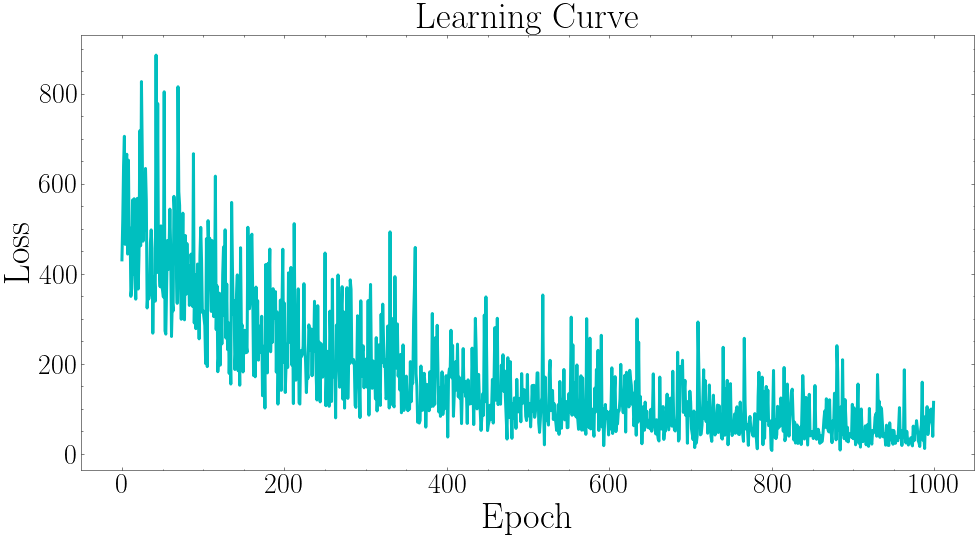

In [34]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

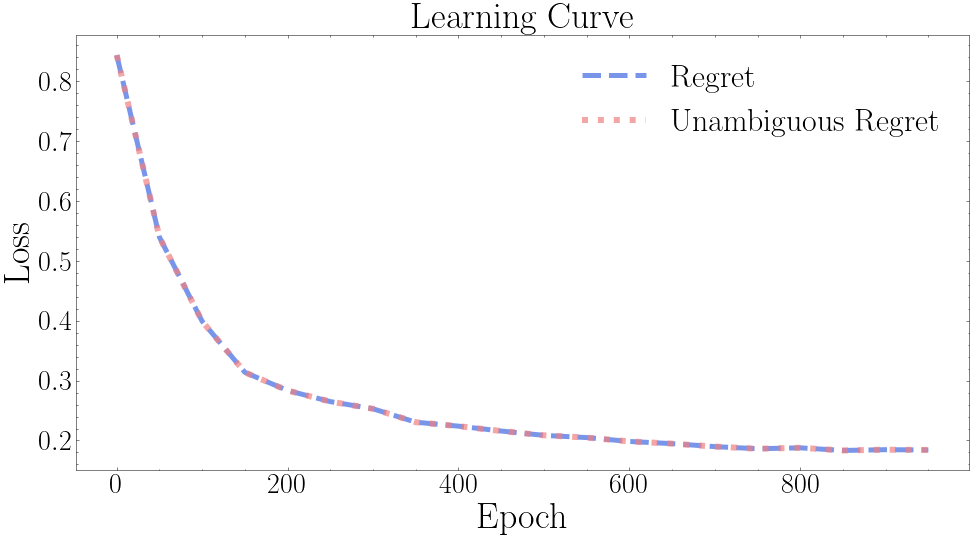

In [35]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 50), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 50), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [36]:
# evaluate
spoloss = pyepo.metric.regret(reg, tsp_model, tsp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, tsp_model, tsp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 18.42%
Normalized Unambiguous Regret: 18.42%


In [37]:
reg.eval()
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print("    True sol: " + " -> ".join(map(str, tour)) + ", True obj: {:.2f}".format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print("    True sol: " + " -> ".join(map(str, tour)) + ", True obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 8.75, 9.31, 2.73, 3.50, 8.66, 40.55, 4.25, 6.82, 14.28, 4.39, 7.52, 7.20, 3.26, 30.17, 29.18, 1.01, 5.14, 33.29, 19.53, 6.80, 8.97, 4.07, 7.09, 7.45, 15.13, 4.36, 2.15, 5.96, 8.67, 3.37, 7.06, 7.40, 3.66, 1.88, 40.05, 9.72, 23.29, 8.37, 7.83, 2.34, 4.44, 3.56, 4.97, 4.73, 8.80, 7.37, 3.34, 17.69, 2.57, 6.29, 2.93, 2.79, 9.77, 3.73, 31.61, 7.88, 8.03, 16.39, 19.05, 13.25, 18.57, 6.38, 2.63, 2.21, 10.42, 1.43, 4.15, 4.08, 5.67, 11.99, 4.36, 11.16, 2.51, 57.21, 1.30, 2.71, 4.62, 6.08, 16.69, 6.13, 2.89, 3.35, 4.51, 9.00, 3.50, 7.72, 2.58, 3.96, 10.73, 1.93, 2.78, 4.14, 2.92, 1.21, 4.39, 2.28, 6.34, 4.17, 7.77, 2.32, 3.41, 4.03, 12.41, 1.91, 6.59, 3.27, 3.83, 16.07, 5.77, 7.84, 3.18, 5.25, 7.60, 22.02, 6.58, 3.20, 4.03, 6.27, 5.93, 42.69, 14.68, 3.62, 3.48, 2.13, 6.03, 27.73, 6.08, 8.52, 15.93, 12.77, 13.80, 4.10, 12.82, 9.07, 15.54, 2.35, 7.15, 5.56, 3.55, 7.74, 2.46, 6.93, 2.25, 9.74, 3.88, 14.19, 25.04, 94.87, 3.92, 4.19, 34.19, 4.20, 1.88, 1.31, 4.01, 6.16, 0.7

    True sol: 0 -> 5 -> 18 -> 2 -> 6 -> 14 -> 15 -> 1 -> 7 -> 4 -> 3 -> 12 -> 8 -> 13 -> 10 -> 9 -> 17 -> 19 -> 16 -> 11 -> 0, True obj: 41.59
    True sol: 0 -> 11 -> 16 -> 6 -> 14 -> 2 -> 18 -> 5 -> 13 -> 8 -> 12 -> 3 -> 17 -> 9 -> 10 -> 7 -> 4 -> 15 -> 1 -> 19 -> 0, True obj: 46.07

Sample 8:
    True cost: 3.17, 1.38, 17.42, 9.43, 9.85, 1.36, 5.25, 3.80, 3.28, 4.50, 2.44, 22.83, 1.28, 0.86, 73.04, 1.50, 8.42, 3.00, 1.66, 4.15, 1.70, 7.67, 3.23, 3.79, 11.10, 114.02, 15.75, 6.22, 9.06, 8.99, 8.54, 3.81, 45.94, 6.27, 6.09, 4.47, 1.52, 10.41, 90.02, 1.69, 29.66, 3.53, 3.73, 3.96, 17.13, 8.51, 3.05, 11.91, 3.77, 7.35, 28.39, 12.17, 5.37, 16.28, 3.09, 9.65, 3.27, 2.43, 3.72, 3.03, 2.51, 7.53, 3.09, 11.69, 5.92, 1.38, 1.77, 4.93, 4.48, 2.02, 8.82, 5.91, 13.57, 4.06, 12.79, 2.51, 3.06, 5.20, 4.10, 5.80, 9.60, 3.45, 41.82, 11.42, 5.51, 6.09, 31.41, 3.65, 19.19, 7.84, 20.79, 178.71, 2.61, 8.21, 3.04, 18.28, 3.60, 1.51, 1.76, 8.52, 11.24, 2.88, 5.96, 7.72, 7.54, 5.18, 13.14, 3.79, 4.67, 2.69,

## SPO+ Rel

In [38]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [39]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [40]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(tsp_model_rel, processes=1)

Num of cores: 1


In [41]:
# train model
num_epochs = 1000
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(tsp_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 50 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, tsp_model, tsp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, tsp_model, tsp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  50, Loss: 453.6887, Regret: 96.7464%, Unambiguous Regret: 96.7654%
Epoch 100, Loss: 456.4633, Regret: 69.3985%, Unambiguous Regret: 69.3985%
Epoch 150, Loss: 297.2809, Regret: 52.1048%, Unambiguous Regret: 52.1048%
Epoch 200, Loss: 181.3240, Regret: 42.5257%, Unambiguous Regret: 42.5545%
Epoch 250, Loss: 186.3936, Regret: 36.8879%, Unambiguous Regret: 36.8879%
Epoch 300, Loss: 234.9608, Regret: 32.8399%, Unambiguous Regret: 32.8399%
Epoch 350, Loss: 200.6199, Regret: 29.6928%, Unambiguous Regret: 29.6928%
Epoch 400, Loss: 213.8001, Regret: 28.1201%, Unambiguous Regret: 28.1201%
Epoch 450, Loss:  83.0048, Regret: 27.1261%, Unambiguous Regret: 27.1281%
Epoch 500, Loss:  65.6474, Regret: 25.9595%, Unambiguous Regret: 25.9595%
Epoch 550, Loss: 143.6577, Regret: 25.4184%, Unambiguous Regret: 25.4184%
Epoch 600, Loss:  80.1234, Regret: 24.2482%, Unambiguous Regret: 24.2482%
Epoch 650, Loss:  51.6628, Regret: 24.0596%, Unambiguous Regret: 24.0596%
Epoch 700, Loss: 137.2823, Regret: 23.

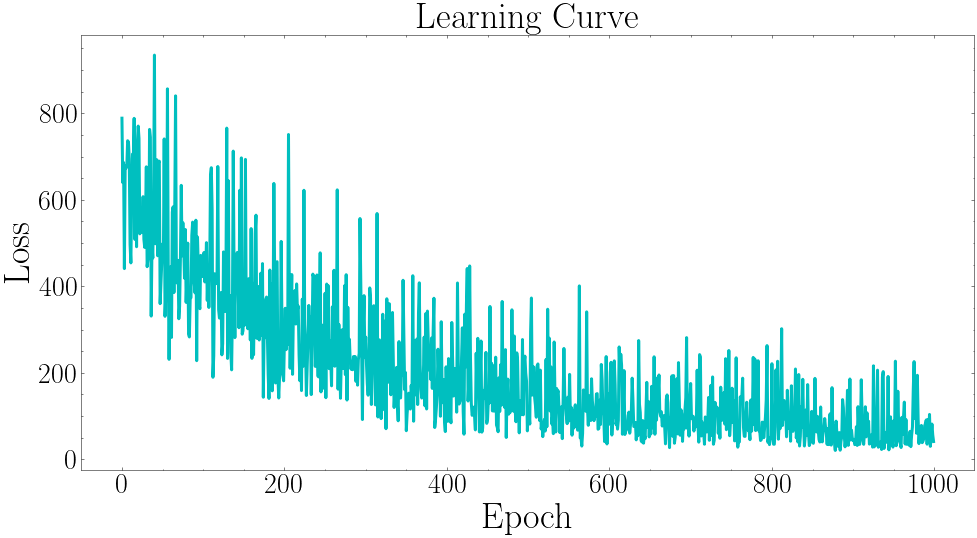

In [42]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

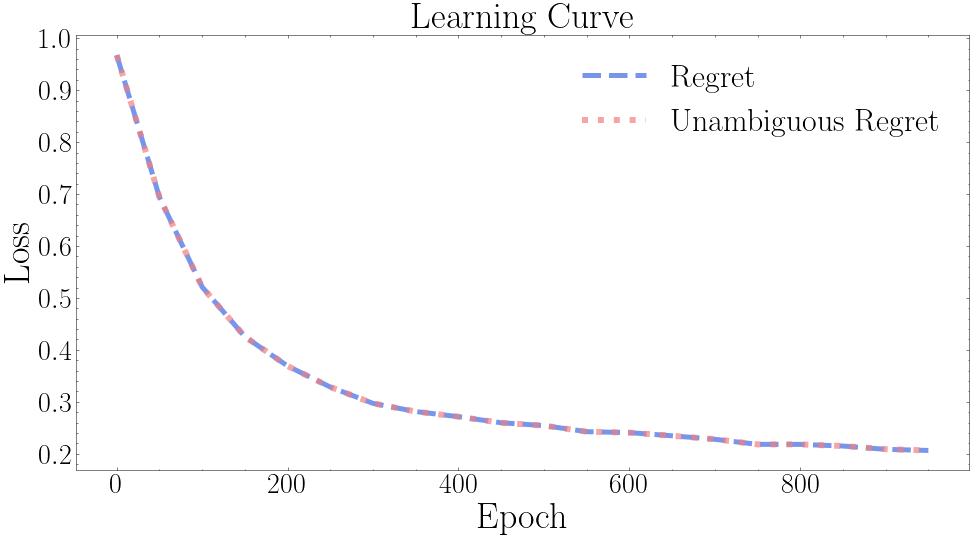

In [43]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 50), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 50), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [44]:
# evaluate
spoloss = pyepo.metric.regret(reg, tsp_model, tsp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, tsp_model, tsp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 20.63%
Normalized Unambiguous Regret: 20.63%


In [45]:
reg.eval()
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print("    True sol: " + " -> ".join(map(str, tour)) + ", True obj: {:.2f}".format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print("    True sol: " + " -> ".join(map(str, tour)) + ", True obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 8.75, 9.31, 2.73, 3.50, 8.66, 40.55, 4.25, 6.82, 14.28, 4.39, 7.52, 7.20, 3.26, 30.17, 29.18, 1.01, 5.14, 33.29, 19.53, 6.80, 8.97, 4.07, 7.09, 7.45, 15.13, 4.36, 2.15, 5.96, 8.67, 3.37, 7.06, 7.40, 3.66, 1.88, 40.05, 9.72, 23.29, 8.37, 7.83, 2.34, 4.44, 3.56, 4.97, 4.73, 8.80, 7.37, 3.34, 17.69, 2.57, 6.29, 2.93, 2.79, 9.77, 3.73, 31.61, 7.88, 8.03, 16.39, 19.05, 13.25, 18.57, 6.38, 2.63, 2.21, 10.42, 1.43, 4.15, 4.08, 5.67, 11.99, 4.36, 11.16, 2.51, 57.21, 1.30, 2.71, 4.62, 6.08, 16.69, 6.13, 2.89, 3.35, 4.51, 9.00, 3.50, 7.72, 2.58, 3.96, 10.73, 1.93, 2.78, 4.14, 2.92, 1.21, 4.39, 2.28, 6.34, 4.17, 7.77, 2.32, 3.41, 4.03, 12.41, 1.91, 6.59, 3.27, 3.83, 16.07, 5.77, 7.84, 3.18, 5.25, 7.60, 22.02, 6.58, 3.20, 4.03, 6.27, 5.93, 42.69, 14.68, 3.62, 3.48, 2.13, 6.03, 27.73, 6.08, 8.52, 15.93, 12.77, 13.80, 4.10, 12.82, 9.07, 15.54, 2.35, 7.15, 5.56, 3.55, 7.74, 2.46, 6.93, 2.25, 9.74, 3.88, 14.19, 25.04, 94.87, 3.92, 4.19, 34.19, 4.20, 1.88, 1.31, 4.01, 6.16, 0.7

    Pred cost: 10.56, -5.44, -8.55, 1.55, -5.50, -8.23, 0.83, -2.59, 21.20, -3.77, -12.59, 12.48, -9.35, -7.00, -0.83, 10.90, -1.10, -0.00, -7.54, 12.42, 0.37, -2.15, 2.99, 3.89, -8.40, 18.02, -5.05, 14.42, 1.99, -13.03, 7.14, -6.56, -13.06, -9.17, 6.99, 7.90, -8.09, -7.71, 11.22, 5.14, -12.57, 21.54, -9.60, 19.63, -3.98, -3.04, 14.21, -10.90, -11.12, 7.81, -0.38, -10.16, -14.15, 5.34, -2.54, 11.10, 15.58, 2.49, 9.90, -0.90, -5.72, -4.79, -14.81, 0.36, -2.85, -6.09, -0.05, -5.04, 3.42, 10.53, 4.98, 12.61, -19.10, 4.36, 1.26, -1.43, 8.35, 5.21, 7.16, -0.68, -4.40, -2.95, -10.04, 12.79, 5.55, -9.93, -0.83, 10.01, 6.54, -11.39, 2.09, 20.99, -2.02, 0.13, 6.51, 9.41, 7.11, -13.69, 0.45, -8.78, 5.14, 4.81, 13.67, 4.12, 5.88, -2.78, -11.32, 14.34, -14.56, 7.74, 0.09, 8.54, 10.93, -13.38, -8.49, 10.62, 4.34, -1.94, 7.59, 11.52, 27.36, 3.98, 3.17, -9.53, 10.52, 14.38, -7.77, -15.53, -7.79, -9.74, -12.73, -9.17, 12.20, 8.71, -2.71, -12.64, 2.95, 3.90, 2.13, 9.32, -10.75, -7.74, -13.98, 7.17, 2.9

## Black-Box 

In [46]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [47]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [48]:
# set loss
bb = pyepo.func.blackboxOpt(tsp_model, lambd=20, processes=1)
criterion = nn.L1Loss()

Num of cores: 1


In [49]:
# train model``
num_epochs = 1000
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(tsp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 50 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, tsp_model, tsp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, tsp_model, tsp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  50, Loss:   4.9897, Regret: 46.8368%, Unambiguous Regret: 46.8368%
Epoch 100, Loss:   1.2987, Regret: 43.7973%, Unambiguous Regret: 43.7973%
Epoch 150, Loss:   0.6378, Regret: 37.8118%, Unambiguous Regret: 37.8142%
Epoch 200, Loss:   0.0268, Regret: 46.5962%, Unambiguous Regret: 46.5988%
Epoch 250, Loss:  15.2411, Regret: 42.6678%, Unambiguous Regret: 42.6678%
Epoch 300, Loss:   6.8883, Regret: 47.5122%, Unambiguous Regret: 47.5221%
Epoch 350, Loss:   0.2043, Regret: 40.8538%, Unambiguous Regret: 40.8538%
Epoch 400, Loss:   0.0990, Regret: 42.1801%, Unambiguous Regret: 42.1801%
Epoch 450, Loss:   0.8484, Regret: 46.2625%, Unambiguous Regret: 46.2648%
Epoch 500, Loss:   1.5079, Regret: 38.3179%, Unambiguous Regret: 38.3179%
Epoch 550, Loss:   0.1521, Regret: 38.6644%, Unambiguous Regret: 38.6644%
Epoch 600, Loss:   2.0779, Regret: 37.9788%, Unambiguous Regret: 37.9956%
Epoch 650, Loss:   0.4504, Regret: 36.8855%, Unambiguous Regret: 36.9251%
Epoch 700, Loss:   0.7299, Regret: 38.

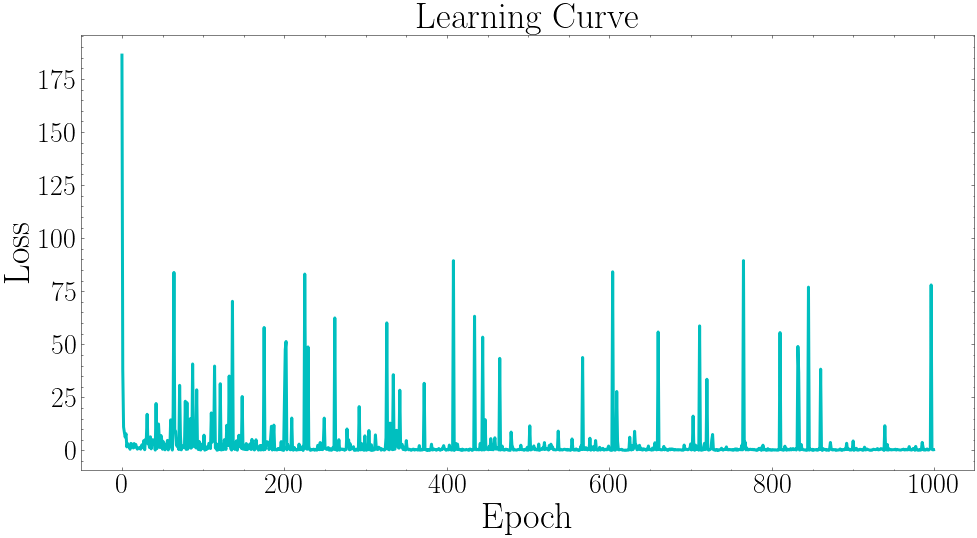

In [50]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

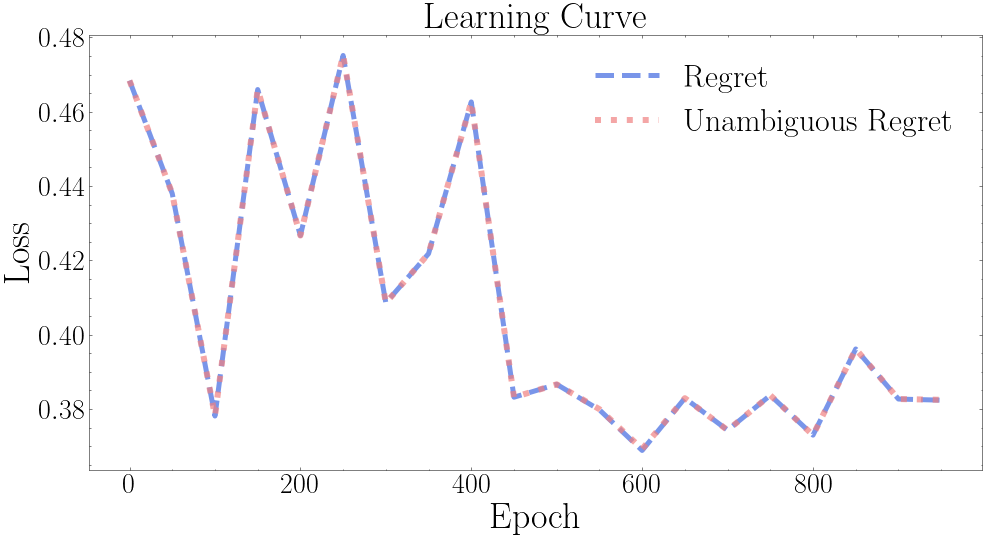

In [51]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 50), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 50), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [52]:
# evaluate
spoloss = pyepo.metric.regret(reg, tsp_model, tsp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, tsp_model, tsp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 38.24%
Normalized Unambiguous Regret: 38.25%


In [53]:
reg.eval()
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print("    True sol: " + " -> ".join(map(str, tour)) + ", True obj: {:.2f}".format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print("    True sol: " + " -> ".join(map(str, tour)) + ", True obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 8.75, 9.31, 2.73, 3.50, 8.66, 40.55, 4.25, 6.82, 14.28, 4.39, 7.52, 7.20, 3.26, 30.17, 29.18, 1.01, 5.14, 33.29, 19.53, 6.80, 8.97, 4.07, 7.09, 7.45, 15.13, 4.36, 2.15, 5.96, 8.67, 3.37, 7.06, 7.40, 3.66, 1.88, 40.05, 9.72, 23.29, 8.37, 7.83, 2.34, 4.44, 3.56, 4.97, 4.73, 8.80, 7.37, 3.34, 17.69, 2.57, 6.29, 2.93, 2.79, 9.77, 3.73, 31.61, 7.88, 8.03, 16.39, 19.05, 13.25, 18.57, 6.38, 2.63, 2.21, 10.42, 1.43, 4.15, 4.08, 5.67, 11.99, 4.36, 11.16, 2.51, 57.21, 1.30, 2.71, 4.62, 6.08, 16.69, 6.13, 2.89, 3.35, 4.51, 9.00, 3.50, 7.72, 2.58, 3.96, 10.73, 1.93, 2.78, 4.14, 2.92, 1.21, 4.39, 2.28, 6.34, 4.17, 7.77, 2.32, 3.41, 4.03, 12.41, 1.91, 6.59, 3.27, 3.83, 16.07, 5.77, 7.84, 3.18, 5.25, 7.60, 22.02, 6.58, 3.20, 4.03, 6.27, 5.93, 42.69, 14.68, 3.62, 3.48, 2.13, 6.03, 27.73, 6.08, 8.52, 15.93, 12.77, 13.80, 4.10, 12.82, 9.07, 15.54, 2.35, 7.15, 5.56, 3.55, 7.74, 2.46, 6.93, 2.25, 9.74, 3.88, 14.19, 25.04, 94.87, 3.92, 4.19, 34.19, 4.20, 1.88, 1.31, 4.01, 6.16, 0.7